In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import datetime as dt
from torch.utils.data.dataloader import DataLoader
from datetime import datetime
from dataset.electricity_dataset import electricity_pre
from pandas import read_csv
import pandas
from datetime import datetime
import os
from matplotlib import pyplot
import warnings
from pandas import read_csv, DataFrame
import os
import torch
from pandas import read_csv
from datetime import datetime
import os
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
gc =0
GC=[]

In [3]:
import random
np.set_printoptions(precision=4)


In [4]:
hir=[[0,56],[0,14],[14,28],[28,42],[42,56]]

In [5]:
for i in range(0,56,2):
    hir.append([i,i+2])

In [6]:
ht=[]
for i in hir:
    ht.append([i[0]+33,i[1]+33])

In [7]:
import pandas as pd

In [8]:
data = pd.read_csv("tourism.csv") 

In [9]:
bottom=list(data.iloc[:,-56:].columns.values)

In [10]:
warnings.filterwarnings('ignore')
now = datetime.now()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
#  probabalistic model with likelihood function
class model(nn.Module):
    def __init__(self, num_lstms, input_dim, output_dim=1, hidden_dim=64):
        super(model, self).__init__()
        self.lstm_out = hidden_dim
        self.num_lstms = num_lstms
        lstms = []
        
        lstms.append(nn.LSTMCell(input_dim, self.lstm_out))
        for i in range(1, self.num_lstms):
            lstms.append(nn.LSTMCell(self.lstm_out, self.lstm_out))
        self.lstms = nn.ModuleList(lstms)
        # μ and σ  distibution -> next point for every t_i.prediction length is from output dimensions
        self.mean = nn.Linear(self.lstm_out, output_dim)
        self.std = nn.Linear(self.lstm_out, output_dim)

        
    def forward(self, input, covariates, future = 0):
        dev = input.device
        means = torch.Tensor().to(dev)
        stds = torch.Tensor().to(dev)
        outputs = []
        h_t = []
        c_t = []
        cond_ctx_len = input.size(1)
        pred_ctx_len = future
        #for covariartes concat input and covariates
        if covariates.shape[2] != 0:
            input = torch.cat((input, covariates[:, 0:cond_ctx_len, :]), 2)
        for i in range(0, self.num_lstms):
            h_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
            c_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
        '''
         h(hidden state),c(cell state)-> output of Lstm cell, h(i)-> passed to lstm(i+1) cell, 
         h(i) and c(i) are recurrent for lstm cell(i+1) 
         and the output from previous cell '''
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t[0], c_t[0] = self.lstms[0](input_t.squeeze(1), (h_t[0], c_t[0])) #first cell ->concat of input and covariates, recurrent input 
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))#susquent cells-> prev. output from stack, recurrent input
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        stds = self.softplus(stds)
       
        for i in range(future):
            output_t = torch.cat((mean, covariates[:, cond_ctx_len + i, :]), 1)
            h_t[0], c_t[0] = self.lstms[0](output_t, (h_t[0], c_t[0]))
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            std = self.softplus(std) # avoid infinties
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        means = means.unsqueeze(-1)
        stds = stds.unsqueeze(-1)
        outputs = torch.cat((means, stds), -1)
        return outputs

    def sample(self, mean, std):
        normal_dist = torch.distributions.normal.Normal(mean, std)
        return normal_dist.sample()

    def softplus(self, x):
        softplus = torch.log(1+torch.exp(x))
        softplus = torch.where(softplus==float('inf'), x, softplus)
        return softplus

    def NLL(self, outputs, truth,ht):#negative log liklihood
        print(outputs.shape,truth.shape)
        mean, std = torch.split(outputs, 1, dim=3)
        #print('normal',mean.shape,std.shape)
        global gc
        #print(outputs,truth)
        print(gc)
        gc=gc+1
        print(f"{'NLL':.^20}")
        mean = mean.squeeze(3)
        std = std.squeeze(3)
        print('squeeze',mean.shape,std.shape)
        
        print(mean.shape,truth.shape)
        global GC   
        GC.append([mean,truth])
        
        
        base_ = torch.sub(truth[:, :, -56:], mean[:, :, -56:])
        vl= torch.empty((torch.mean(torch.div(torch.pow(base_, 2), torch.pow(std[:, :, -56:], 2))) + 2*torch.mean(torch.log(std[:, :, -56:]))).shape)
        for i,j in zip(ht,range(len(ht))):
            vl+=torch.mean(torch.div(torch.pow(torch.sub(truth[:, :, j:j+1],torch.sum(mean[:, :, i[0]:i[1]], axis=2).reshape(mean[:, :,0:1].shape)), 2), torch.pow(std[:, :, i[0]:i[1]], 2))) + 2*torch.mean(torch.log(std[:, :,i[0]:i[1]]))            
        loss = (torch.mean(torch.div(torch.pow(base_, 2), torch.pow(std[:, :, -56:], 2))) + 2*torch.mean(torch.log(std[:, :, -56:])))+ vl
        
        #base_ = torch.sub(truth[:, :, :], mean[:, :, :])
        #loss = (torch.mean(torch.div(torch.pow(base_, 2), torch.pow(std[:, :, :], 2))) + 2*torch.mean(torch.log(std[:, :, :])))
        print('loss',loss.shape)
        return loss
    


In [12]:
def date_cv(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [13]:
_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': .1,
    'ctx_win_len': 22,
    'cond_win_len': 10,
    'batch_size': 512,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 89,
    'total_num_targets': 89,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch': 200,
    'num_epochs': 100,
    'data_file': 'trsv.csv',
    'train_test_split':0.7
}

ls_params = _params_
ls_params['num_covariates'] = 0

In [14]:
class utils:
    def __init__(self, dev,_params):
        self.min = 0
        self.max = 0
        self.range = 0
        self.mean = 0
        self.dev = dev
        self._params = _params

    def NRMSE(self, input, target):
        return np.sqrt(torch.nn.functional.mse_loss(input, target).item()) / torch.mean(torch.abs(target))

    def NormDeviation(self, input, target):
        return torch.mean(torch.abs(input - target)) / torch.mean(torch.abs(target))

    def MAE(self, input, target):
        return torch.mean(torch.abs(input - target))

    def split_batch(self, batch):
        num_time_idx = self._params['num_time_idx']
        num_targets = self._params['num_targets']
        total_num_targets = self._params['total_num_targets']
        num_covariates = self._params['num_covariates']    
        b = num_time_idx
        time_idx = batch[:, 1::, :b].to(self.dev).float()
        e = b + num_targets
        input = batch[:, 0:-1, b: e].to(self.dev).float()
        target = batch[:, 1::, b: e].to(self.dev).float()
        e = e - num_targets + total_num_targets
        total_num_covariates = batch.shape[2] - e + 1  
        covariates = time_idx
        b = e
        e = b + num_covariates
        if (num_covariates > 0):
            covariates = torch.cat((time_idx, batch[:, 1::, b: e]), -1)
        return input, target, covariates

    def scale(self, input, covariates):
        
        self.mean = torch.mean(input, dim=1).unsqueeze(1)
        input = input - self.mean
        min = torch.min(input, dim=1)[0].unsqueeze(1)
        max = torch.max(input, dim=1)[0].unsqueeze(1)
        self.range = max - min
        self.range[self.range < 1e-5] = 1e-5
        input = input / self.range

        num_covariates = self._params['num_covariates']
        if (num_covariates > 0):
            mean = torch.mean(covariates, dim=1).unsqueeze(1)
            covariates = covariates - mean
            min = torch.min(covariates, dim=1)[0].unsqueeze(1)
            max = torch.max(covariates, dim=1)[0].unsqueeze(1)
            range = max - min
            range[range < 1e-5] = 1e-5
            covariates = covariates / range
        return input, covariates

    def invert_scale(self, input, probabalistic=False):
        if probabalistic == False:
            return input * self.range + self.mean
        else:
            mean = input[:, :, :, 0]
            std = input[:, :, :, 1]
            scaled_mean = mean * self.range + self.mean
            scaled_std = std * torch.sqrt(self.range)
            return torch.cat((scaled_mean.unsqueeze(-1), scaled_std.unsqueeze(-1)), -1)

In [15]:
'''
dataset = read_csv('dataset/elec.txt', sep=";", decimal=",", header=None, skiprows=[0], parse_dates = [[0]], date_parser=date_cv)
dataset.set_index("0", inplace=True)
weekday = pandas.Series(dataset.index[:].weekday, dtype='int32')
hour = pandas.Series(dataset.index[:].hour, dtype='int32')
minute = pandas.Series(dataset.index[:].minute, dtype='int32')
dataset.insert(len(dataset.columns), 'weekday', weekday.values)
dataset.insert(len(dataset.columns), 'hour', hour.values)
dataset.insert(len(dataset.columns), 'min', minute.values)
dataset.index.name = 'date'
dataset = dataset[35042:]
print(dataset.head(5))
'''

'\ndataset = read_csv(\'dataset/elec.txt\', sep=";", decimal=",", header=None, skiprows=[0], parse_dates = [[0]], date_parser=date_cv)\ndataset.set_index("0", inplace=True)\nweekday = pandas.Series(dataset.index[:].weekday, dtype=\'int32\')\nhour = pandas.Series(dataset.index[:].hour, dtype=\'int32\')\nminute = pandas.Series(dataset.index[:].minute, dtype=\'int32\')\ndataset.insert(len(dataset.columns), \'weekday\', weekday.values)\ndataset.insert(len(dataset.columns), \'hour\', hour.values)\ndataset.insert(len(dataset.columns), \'min\', minute.values)\ndataset.index.name = \'date\'\ndataset = dataset[35042:]\nprint(dataset.head(5))\n'

In [16]:
data.dtypes

Total                  int64
Hol                    int64
VFR                    int64
Bus                    int64
Oth                    int64
                       ...  
WA - oth - noncity     int64
TAS - oth - city       int64
TAS - oth - noncity    int64
NT - oth - city        int64
NT - oth - noncity     int64
Length: 89, dtype: object

In [17]:
data.to_csv('dataset/trsv.csv')

[]

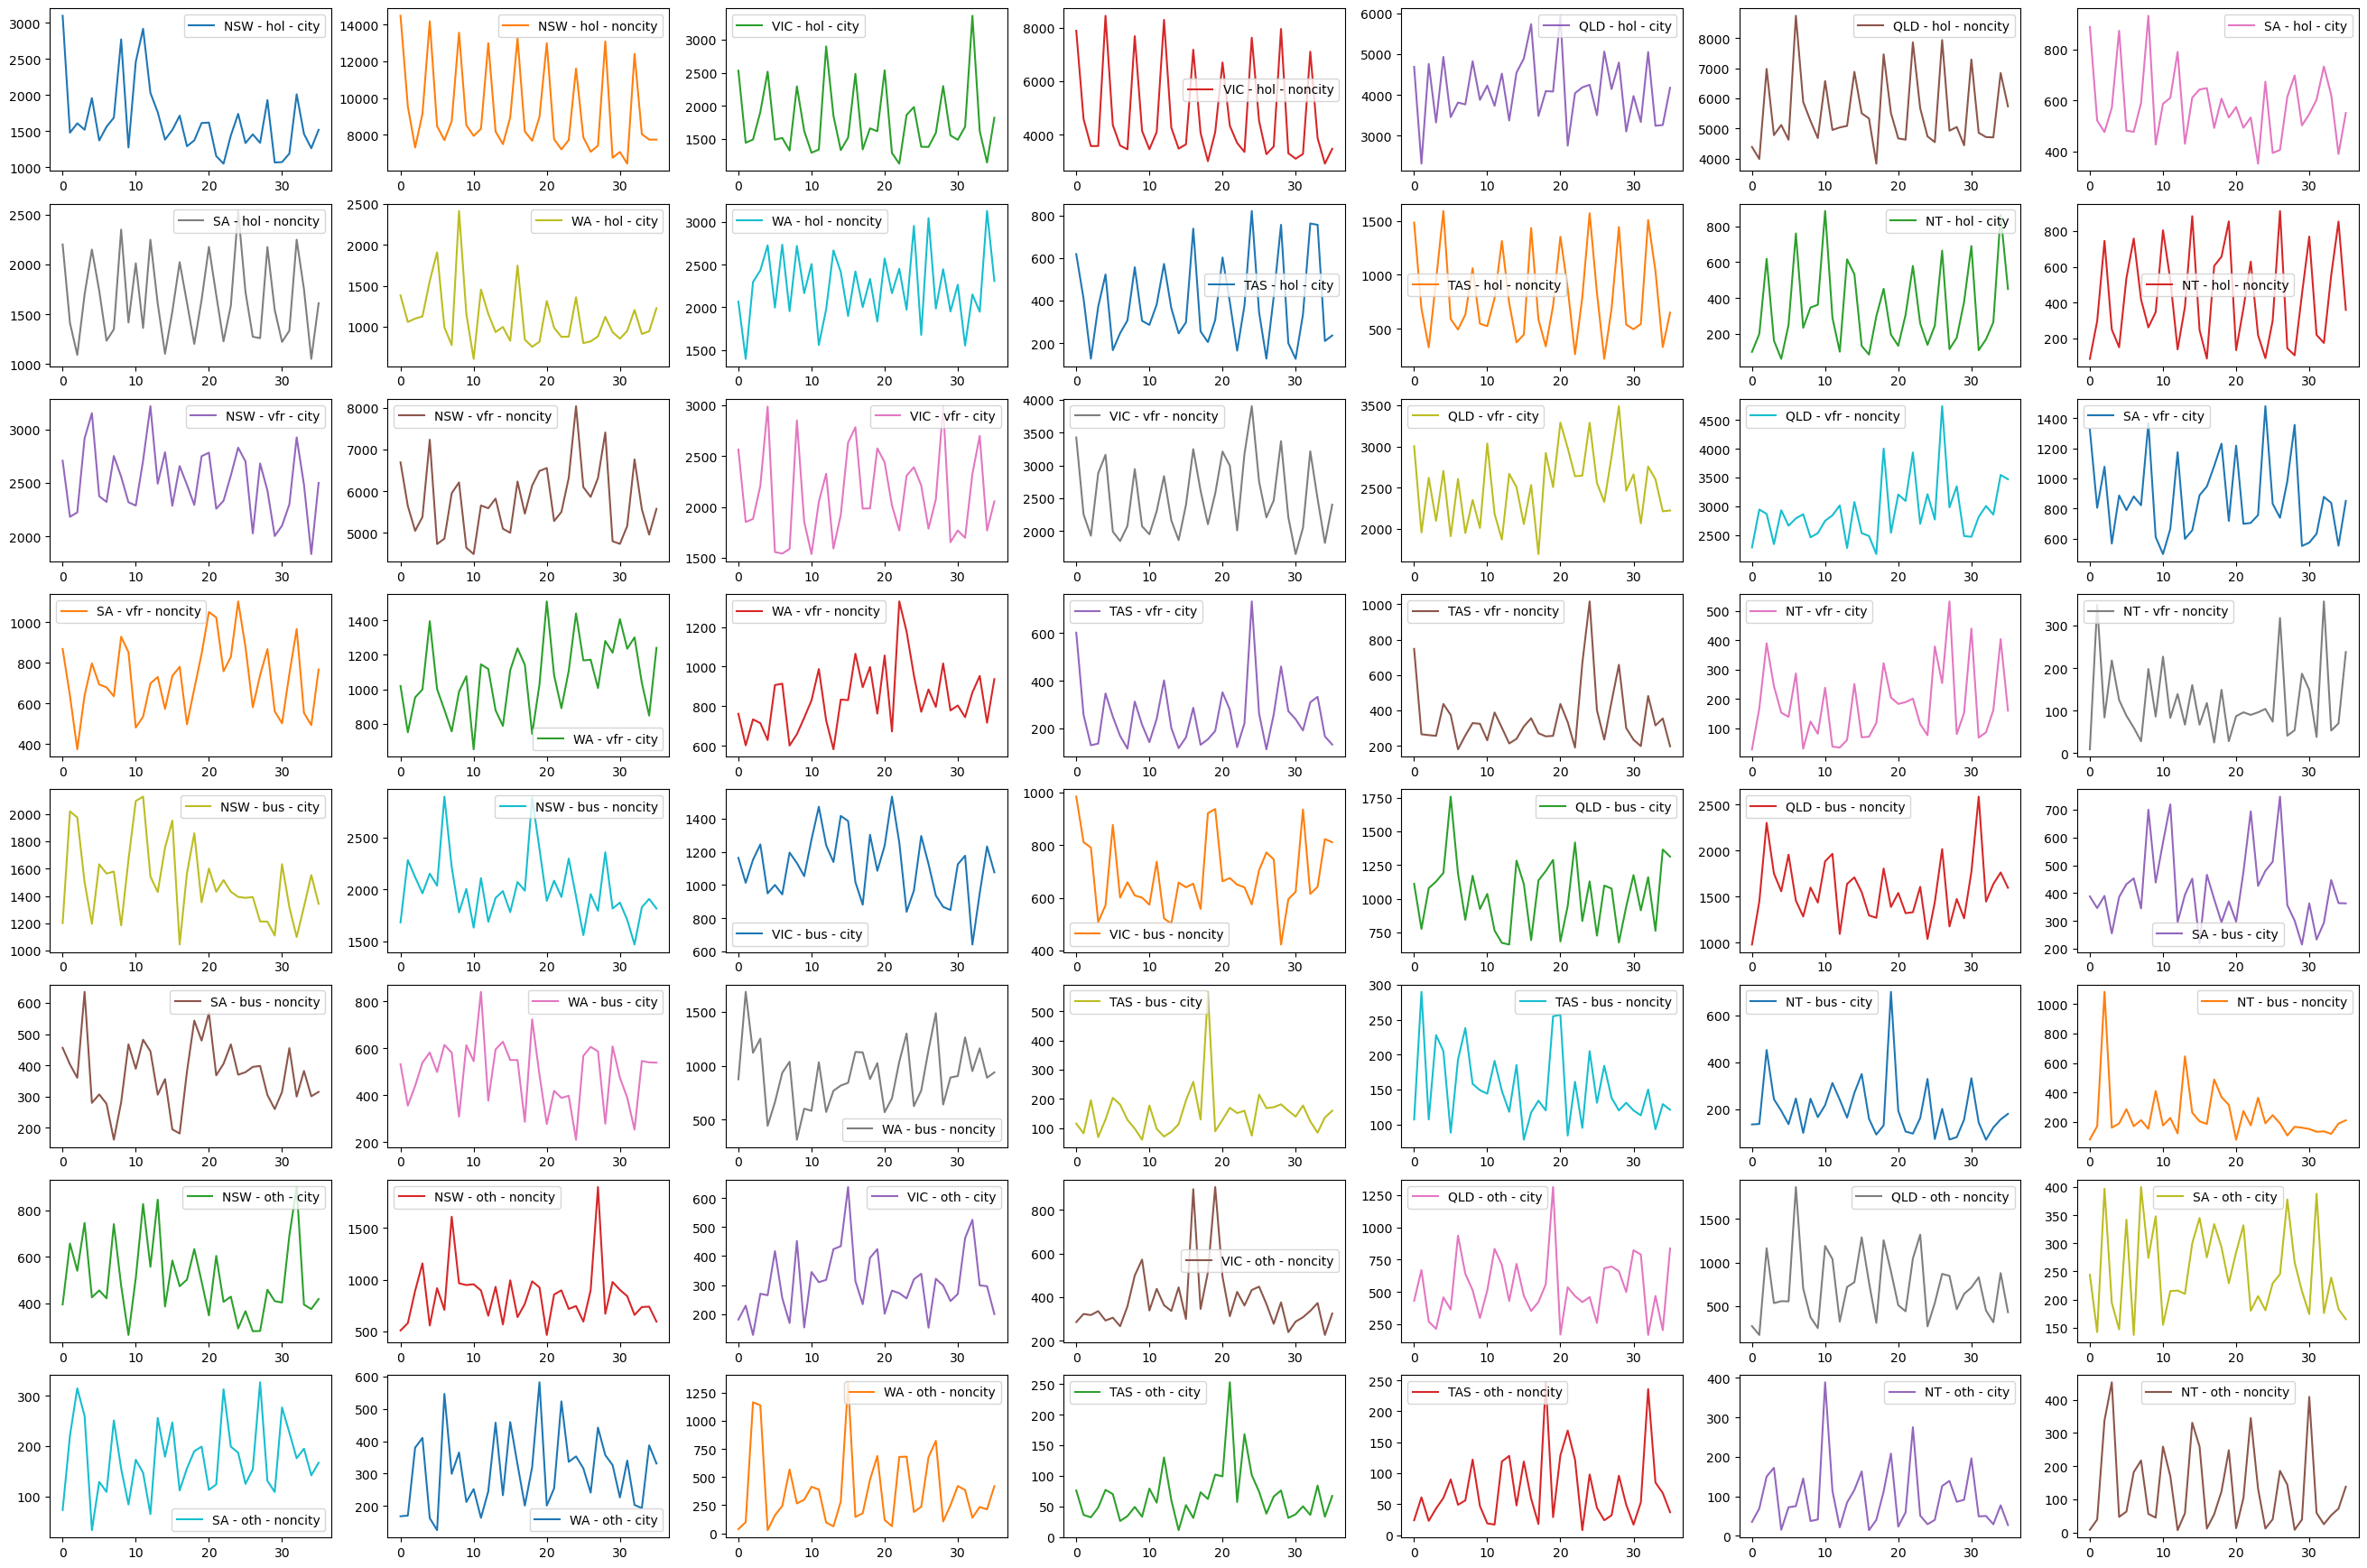

In [18]:
fig, axes = plt.subplots(nrows=8, ncols=7,figsize=(33,22))
data[data.columns.intersection(bottom)].plot(subplots=True, ax=axes)
plt.plot()

In [19]:
class MyDataset(Dataset):
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        rel_time = torch.from_numpy(np.arange(0, self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(self.dev)
        abs_time = torch.from_numpy(np.arange(idx, idx + self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(
            self.dev)
        if (self.num_time_indx == 2):  
            out = torch.cat((rel_time, abs_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 1):  
            out = torch.cat((rel_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 0):  
            out = self.scaled[idx: idx + self.ctx_win_len, :].unsqueeze(0)
        return torch.squeeze(out, 0)
    
    def get_train_test_samplers(self, train_test_split):
        indices = list(range(self.dataset_size))
        print
        split = int(np.floor(train_test_split * self.dataset_size))
        train_indices, test_indices = indices[: split - self.ctx_win_len], indices[split-self.ctx_win_len: ]
        return SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)
    def plot_corr(self, df, size=10):
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(size, size))
        ax.matshow(corr)
        plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
        plt.yticks(range(len(corr.columns)), corr.columns)


In [20]:
class Tourism_pre(MyDataset):
    def __init__(self, csv_file, dev, ctx_win_len, num_time_indx=1):
        self.num_time_indx = num_time_indx
        self.dev = dev
        df = read_csv('dataset/trsv.csv',index_col=0)
        self.ctx_win_len = ctx_win_len
        values = df.values
        values = values.astype('float32')
        self.scaled = values
        self.dataset_size = self.scaled.shape[0]
        self.scaled = torch.from_numpy(self.scaled).float().to(dev)
        self.resolution = 1

In [21]:
params = _params_
dataset_ = Tourism_pre(csv_file=params['data_file'], dev=device, ctx_win_len=params['ctx_win_len'], num_time_indx=params['num_time_idx'])

In [22]:
num_covariates = params['num_covariates']
num_time_idx = params['num_time_idx']
num_targets = params['num_targets']
input_dim = num_time_idx + num_targets + num_covariates
ctx_win_len = params['ctx_win_len']
cond_win_len = params['cond_win_len']
pred_win_len = ctx_win_len - cond_win_len - 1
batch_size = params['batch_size']

In [23]:
model = model(num_lstms=params['num_lstms'], input_dim=input_dim, output_dim=params['num_targets'],hidden_dim=params['hidden_dim']).to(device)
optimizer = optim.Adam(model.parameters(), params['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_step_size'], gamma=params['lr_gamma'])

In [24]:
train_sampler, test_sampler = dataset_.get_train_test_samplers(params['train_test_split'])


In [25]:
train_dataloader = DataLoader(dataset_, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset_, batch_size=1, sampler=test_sampler,shuffle=False, num_workers=0)
max_batches_per_epoch = params['max_batches_per_epoch']
num_epochs = params['num_epochs']

In [26]:
train_sampler

In [27]:
losses = []
batch_num = 1
utils = utils(device, params)
# Trainin loop
def train():
    for epoch in range(0, num_epochs):
        batch_num = 0
        for i, batch in enumerate(train_dataloader):
            if batch_num > max_batches_per_epoch:
                break    
            input, target, covariates = utils.split_batch(batch) #splitting batches : issue with sequence
            #conditioning window input,Prediction window , model op conditioned on previous values
            # model output for the previous step
            input_cond = input[:, 0:cond_win_len, :]
            input_cond, covariates = utils.scale(input_cond, covariates)
            optimizer.zero_grad()
            #forward pass
            out = model(input_cond, covariates, future=pred_win_len)
            out = utils.invert_scale(out, probabalistic=True)
            #rescale
            loss = model.NLL(out, target,ht)
            #loss calc
            loss.backward()
            scheduler.step()
            optimizer.step()
            loss = loss.item()
            losses.append(loss)
            print(f"epoch:{epoch} /{num_epochs}| batch:{batch_num}:loss:{loss}")
            batch_num = batch_num + 1
    return model, losses


In [28]:
model, losses = train()
data='elec'# electricity dataset
date_=str(now).replace(" ", "")
model_save_ = f"{data}_epochs{params['num_epochs']}_{ date_ }"
torch.save(model.state_dict(), model_save_+".pth")


torch.Size([3, 21, 89, 2]) torch.Size([3, 21, 89])
0
........NLL.........
squeeze torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
loss torch.Size([])
epoch:0 /100| batch:0:loss:387468.9375
torch.Size([3, 21, 89, 2]) torch.Size([3, 21, 89])
1
........NLL.........
squeeze torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
loss torch.Size([])
epoch:1 /100| batch:0:loss:385588.40625
torch.Size([3, 21, 89, 2]) torch.Size([3, 21, 89])
2
........NLL.........
squeeze torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
loss torch.Size([])
epoch:2 /100| batch:0:loss:323572.0625
torch.Size([3, 21, 89, 2]) torch.Size([3, 21, 89])
3
........NLL.........
squeeze torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
torch.Size([3, 21, 89]) torch.Size([3, 21, 89])
loss torch.Size([])
epoch:3 /100| batch:0:loss:305209.71875
torch.Size([3, 21, 89, 2]) torch.Size([3, 21, 89])

torch.Size([1, 21, 89, 2]) torch.Size([1, 21, 89])
102
........NLL.........
squeeze torch.Size([1, 21, 89]) torch.Size([1, 21, 89])
torch.Size([1, 21, 89]) torch.Size([1, 21, 89])
loss torch.Size([])
loss (prediction): 1183.25390625


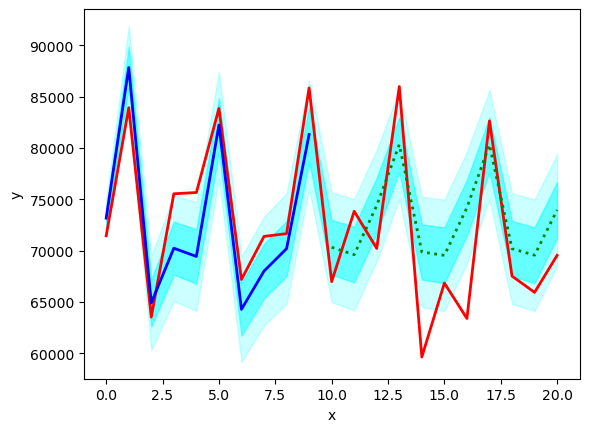

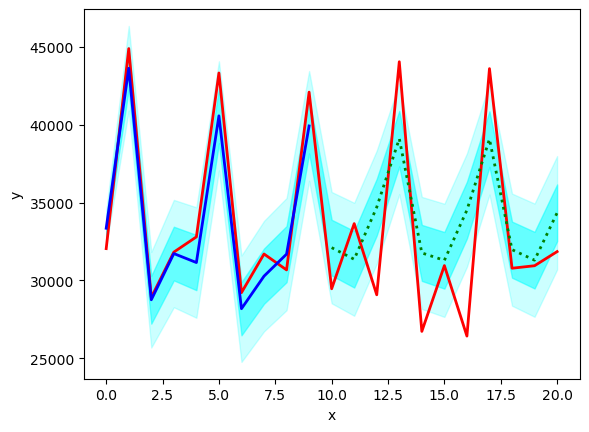

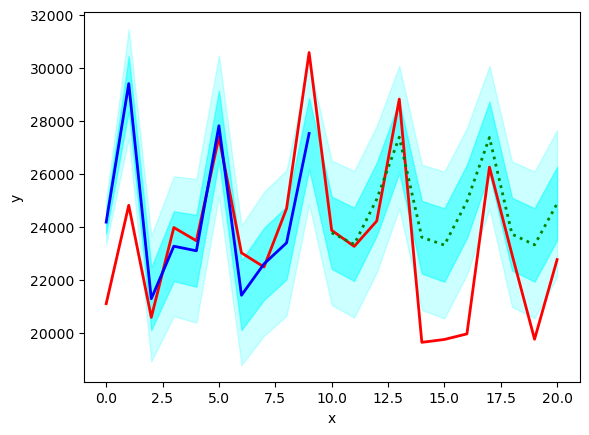

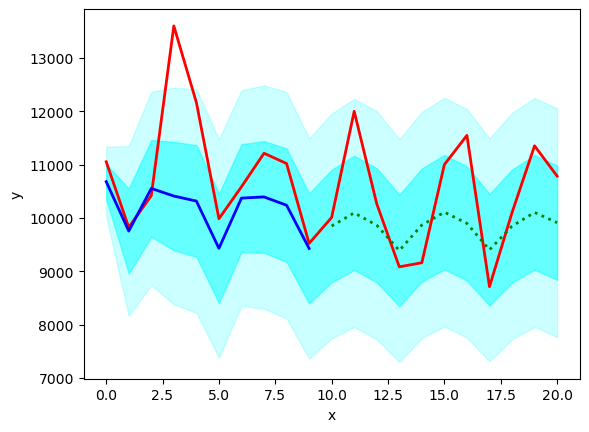

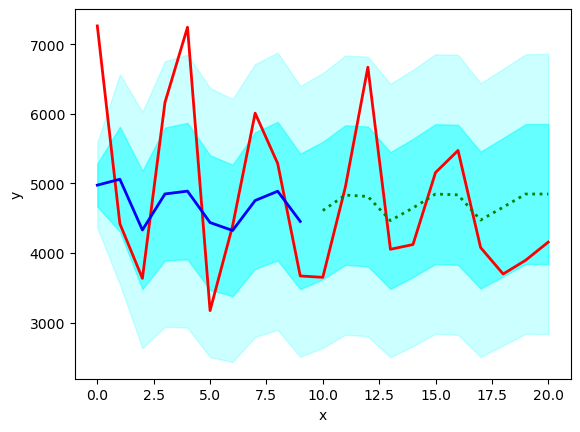

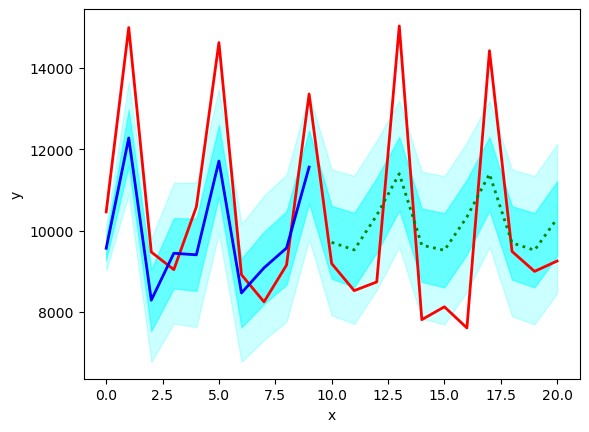

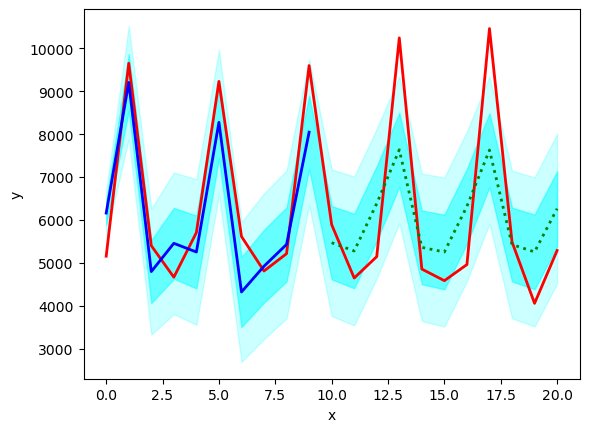

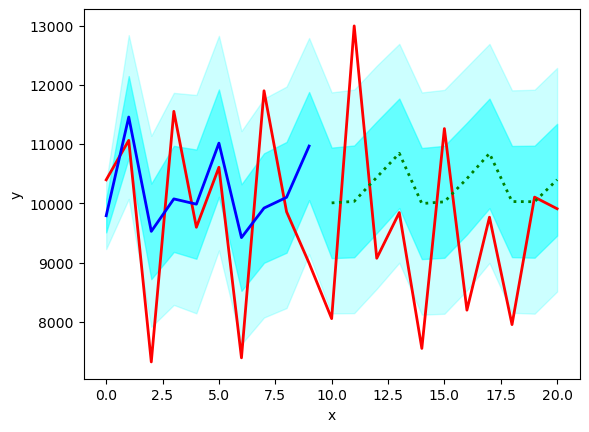

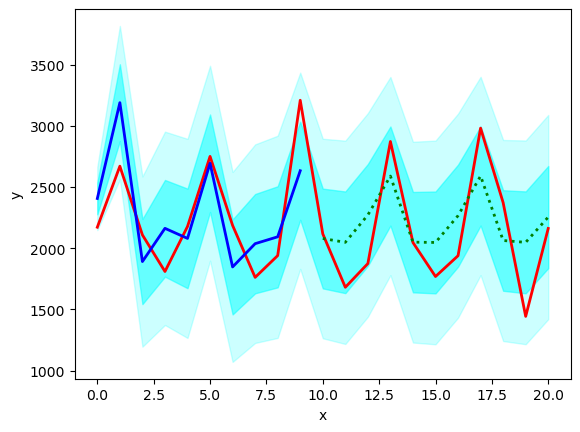

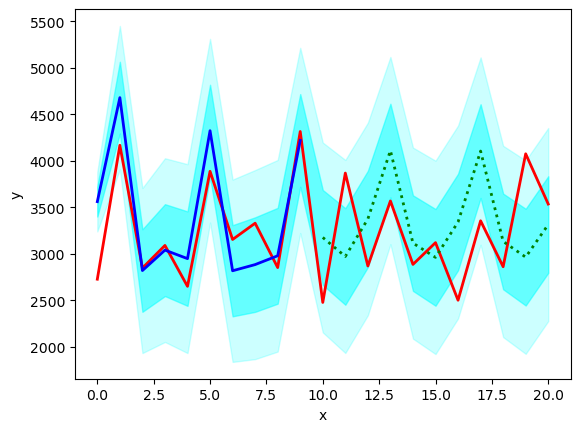

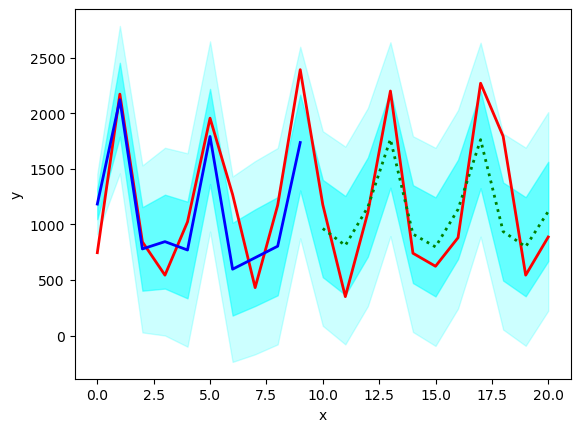

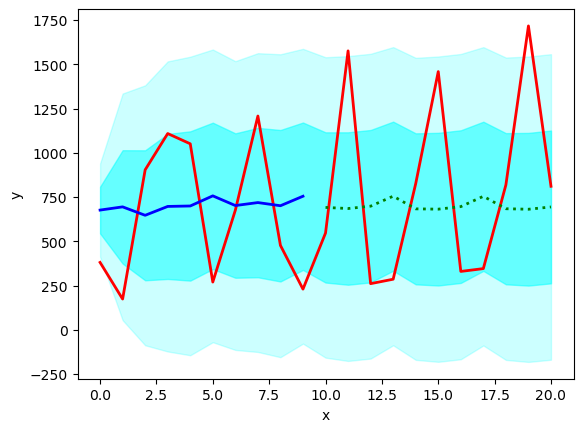

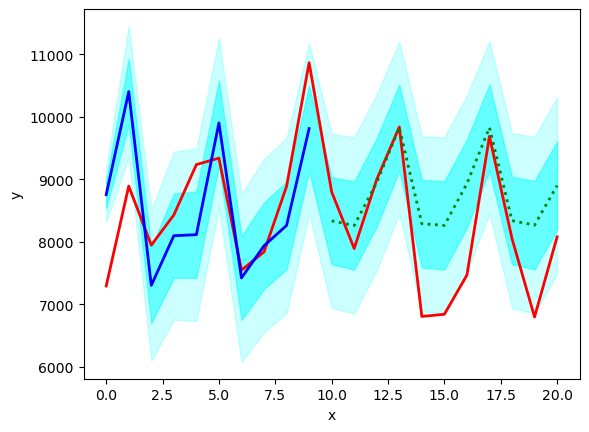

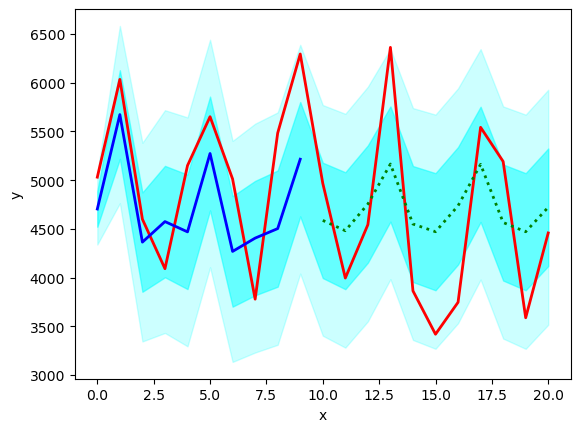

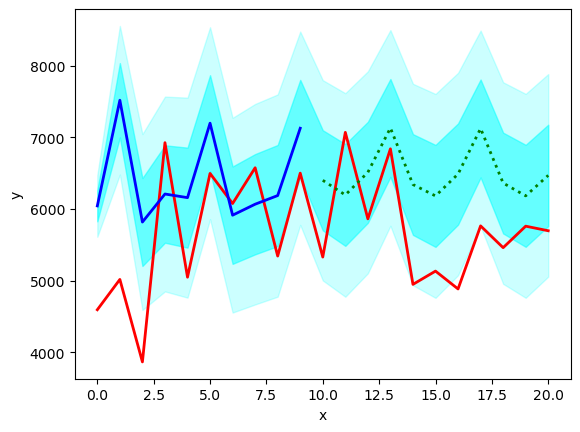

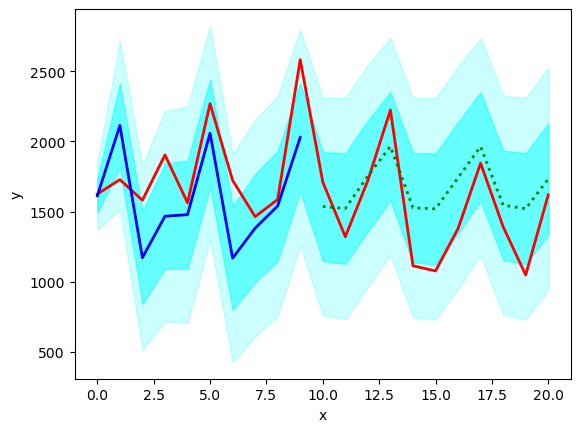

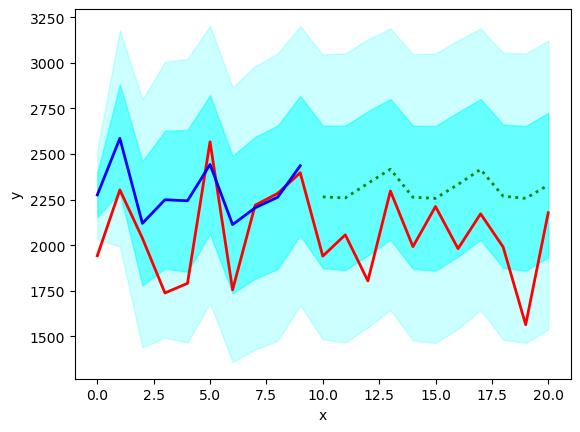

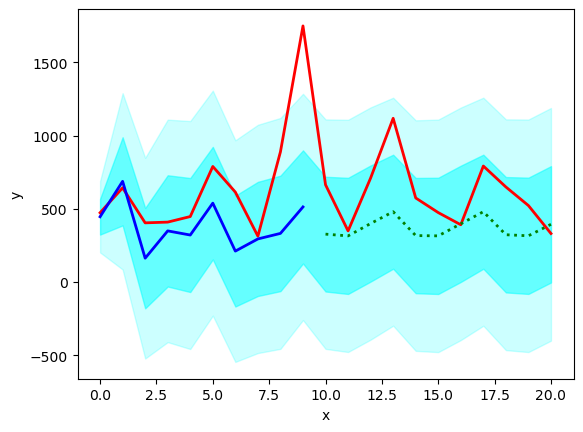

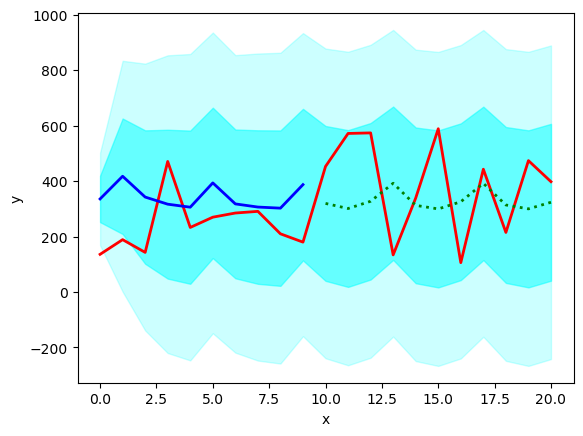

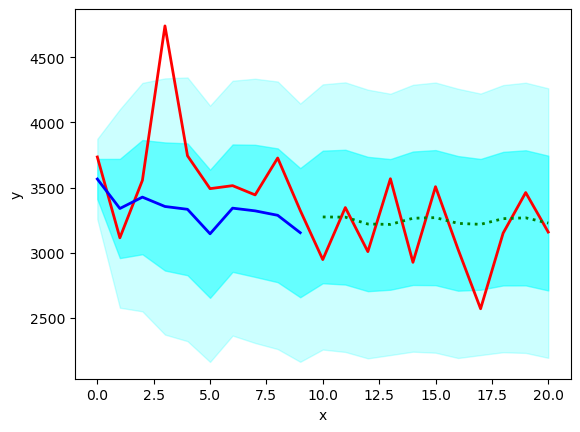

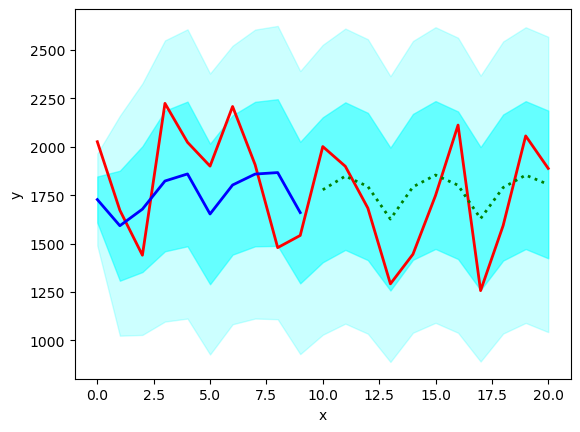

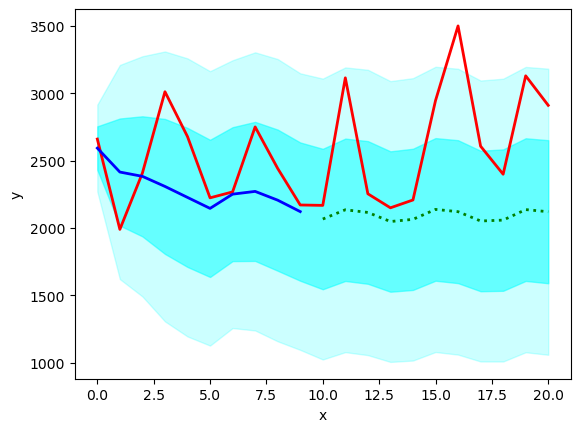

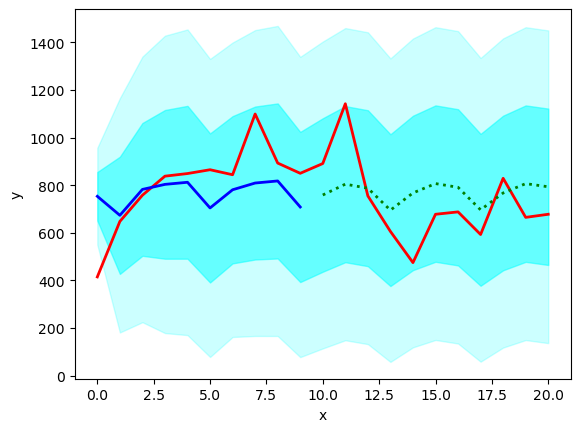

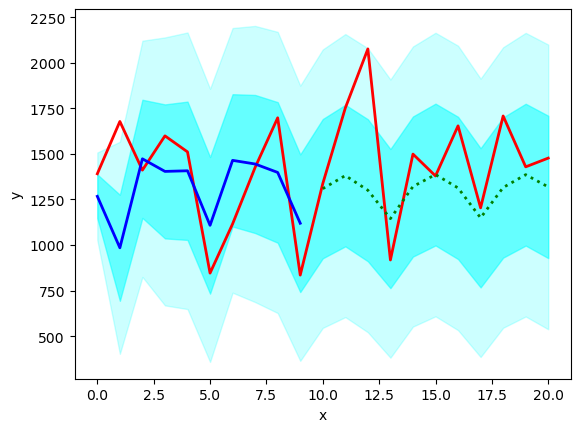

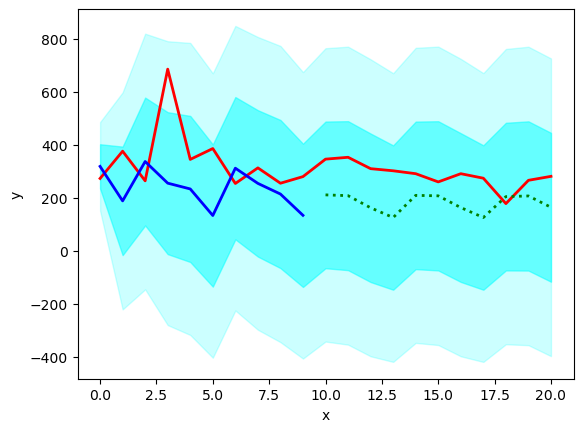

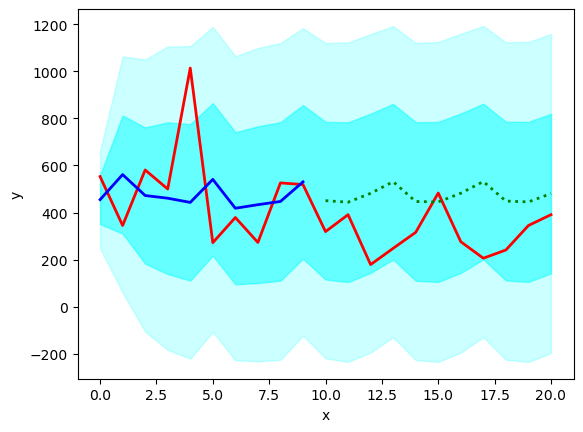

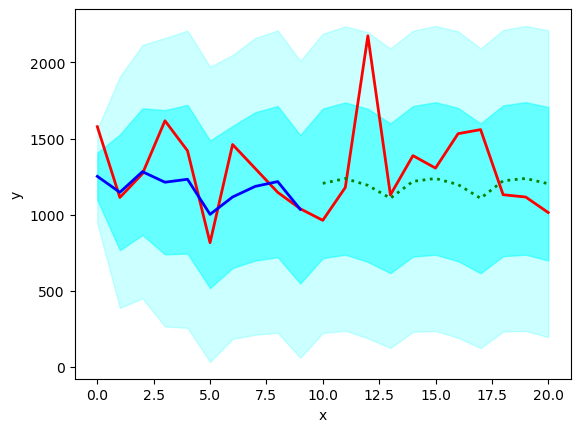

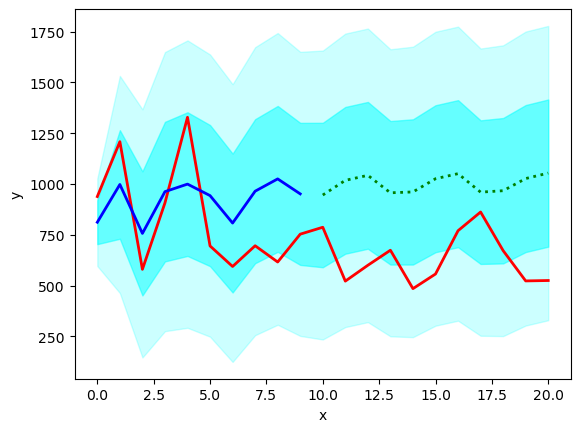

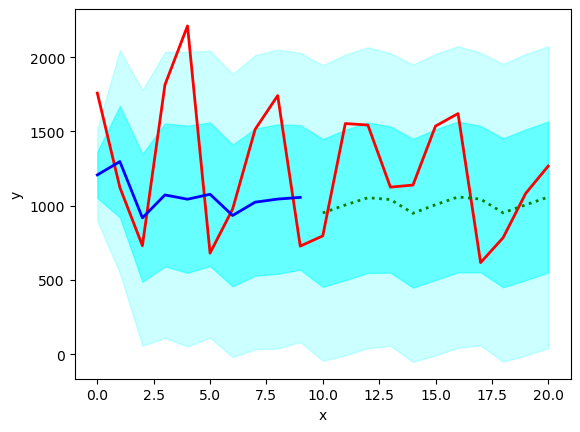

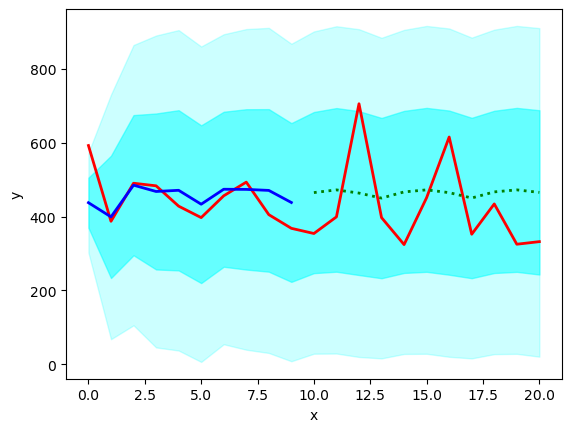

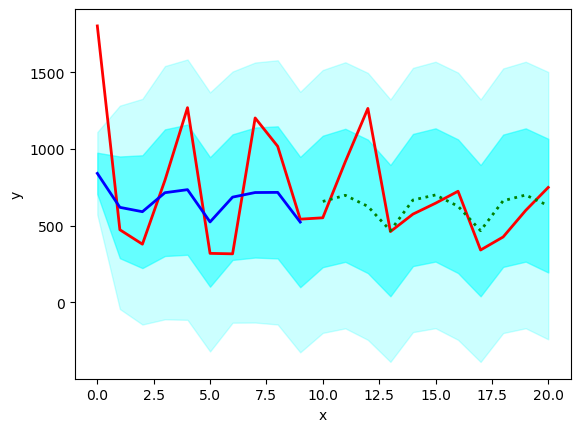

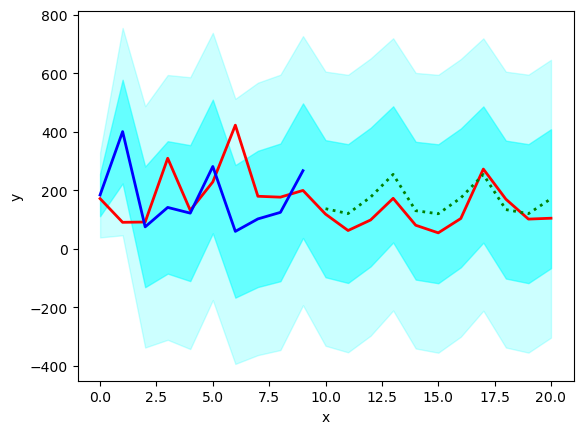

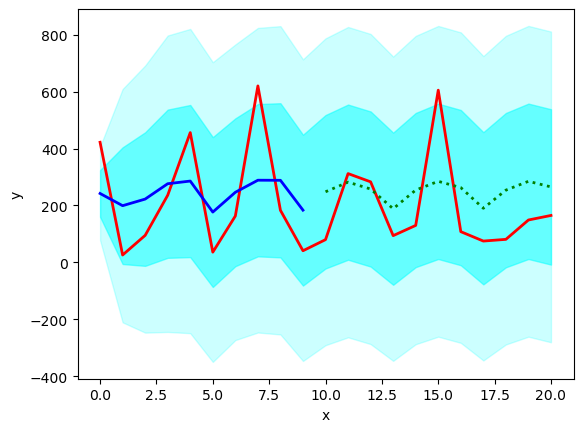

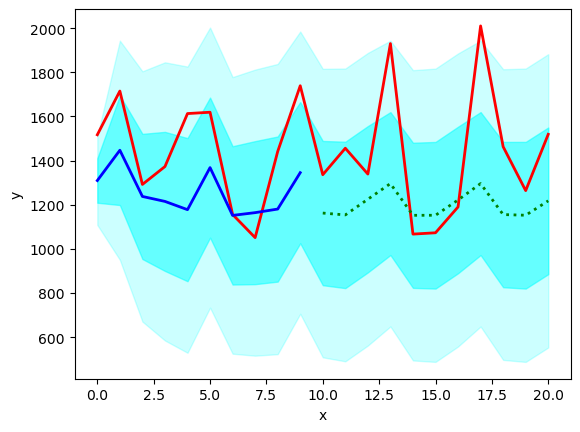

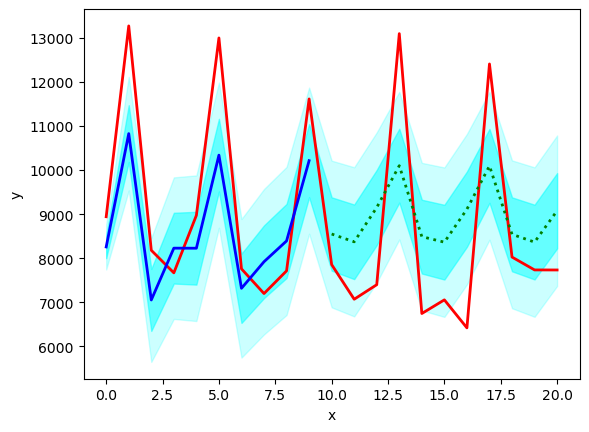

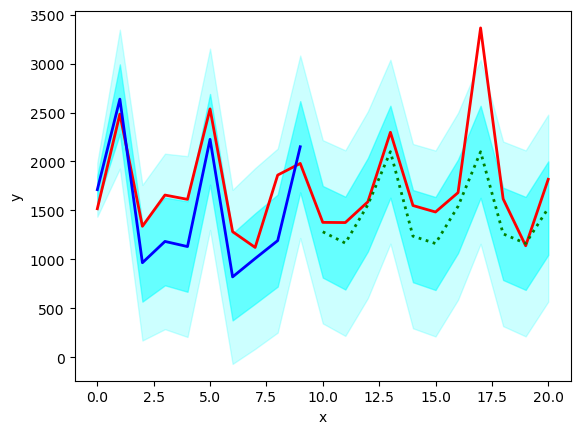

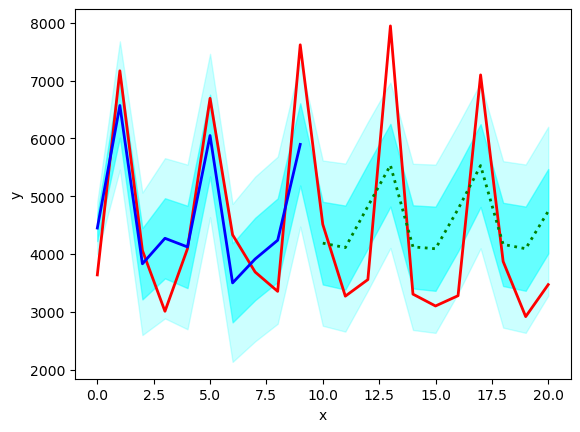

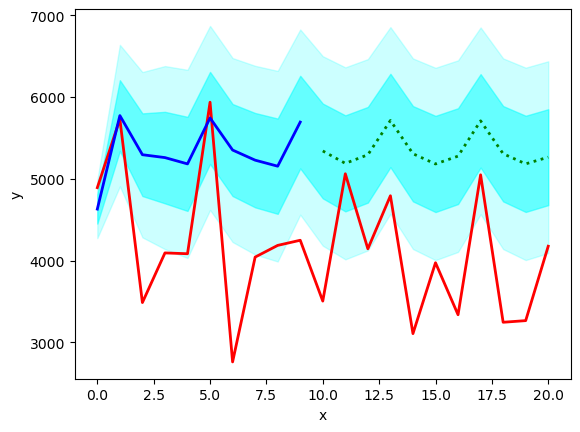

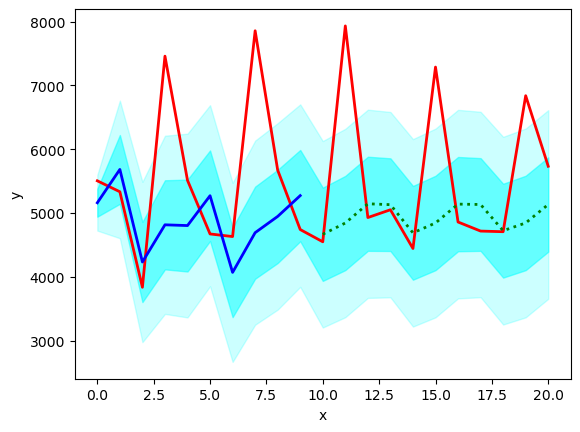

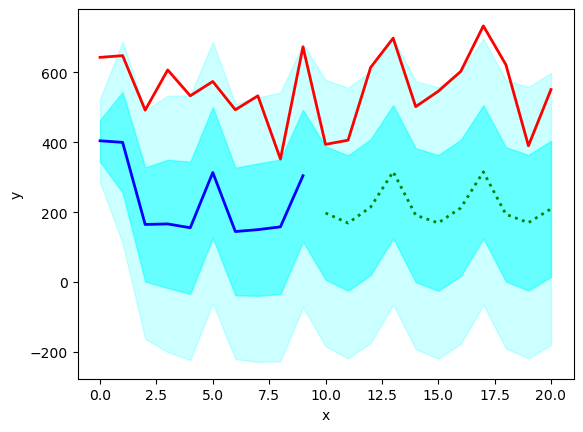

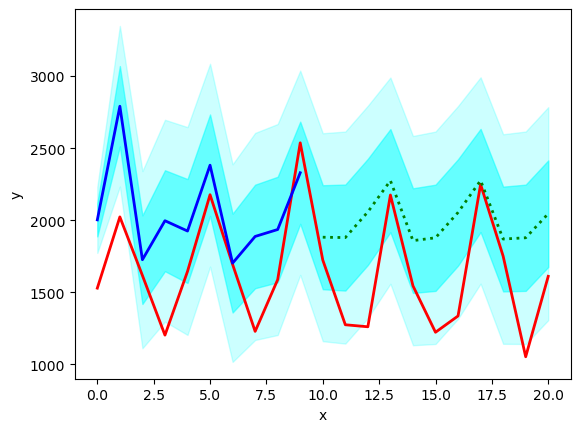

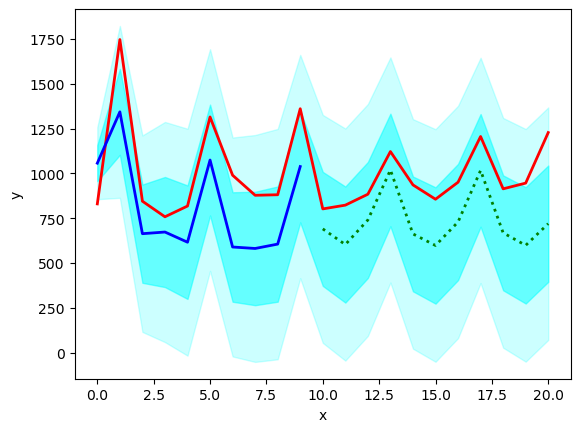

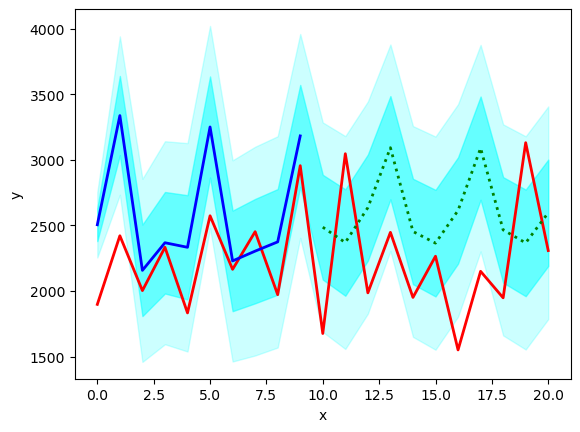

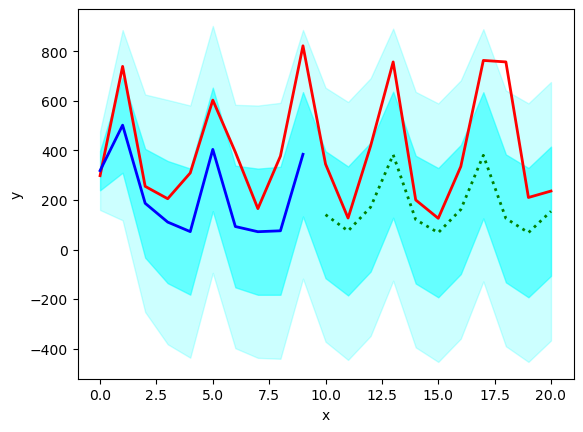

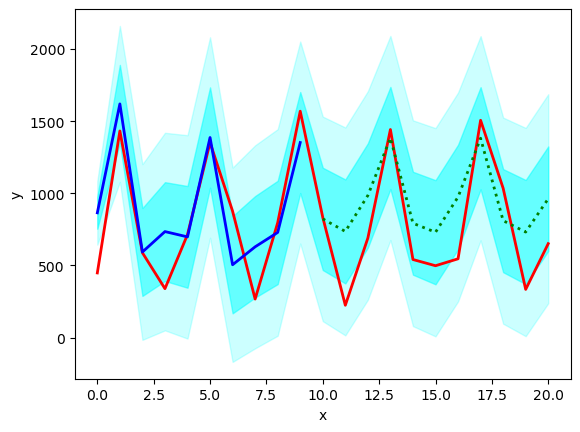

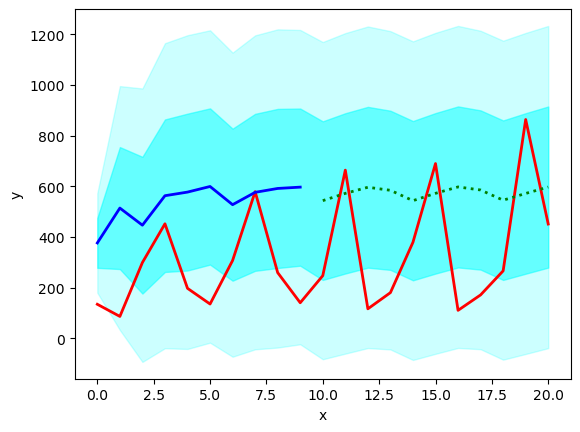

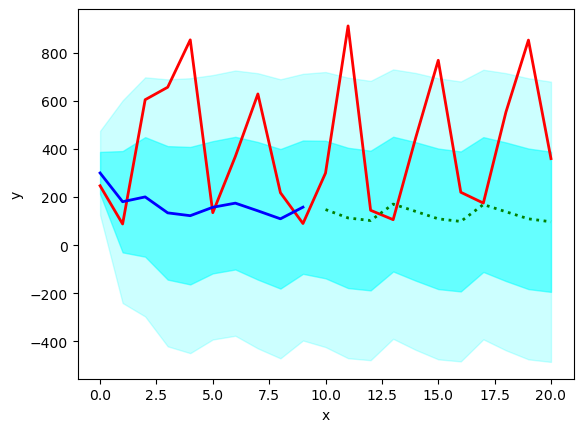

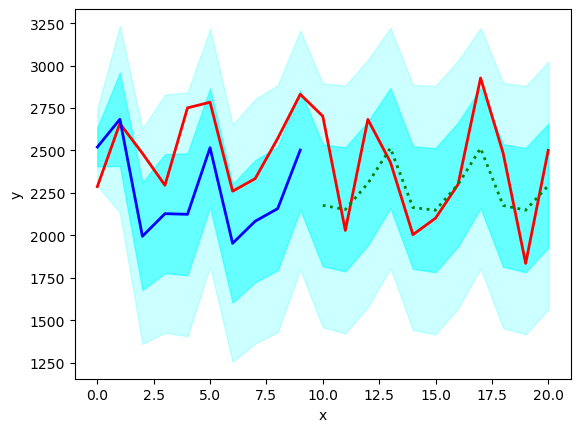

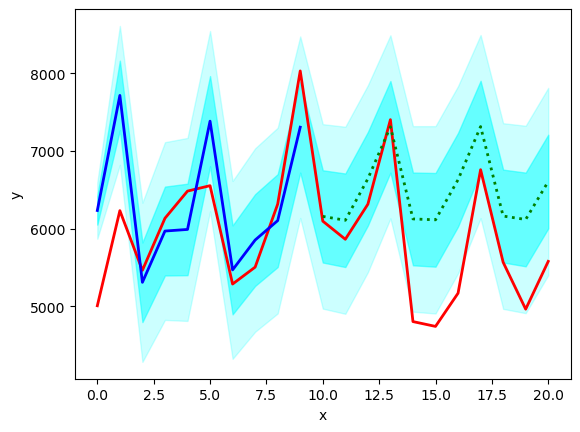

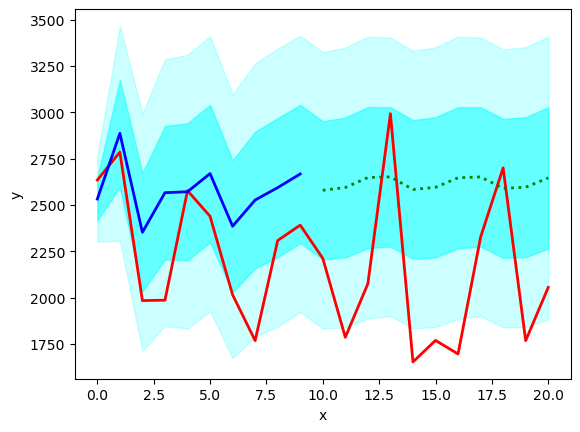

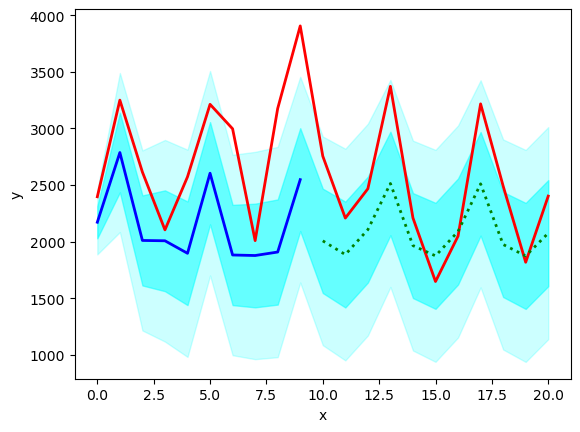

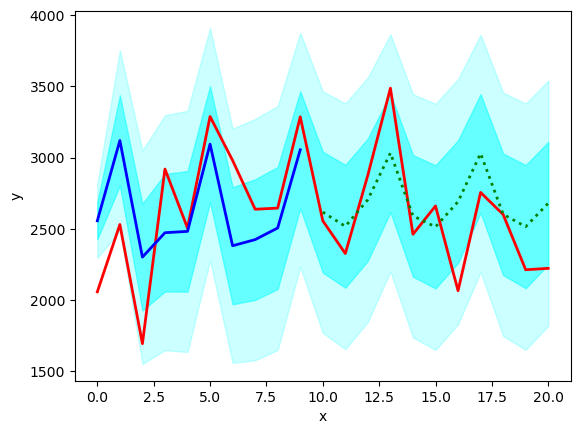

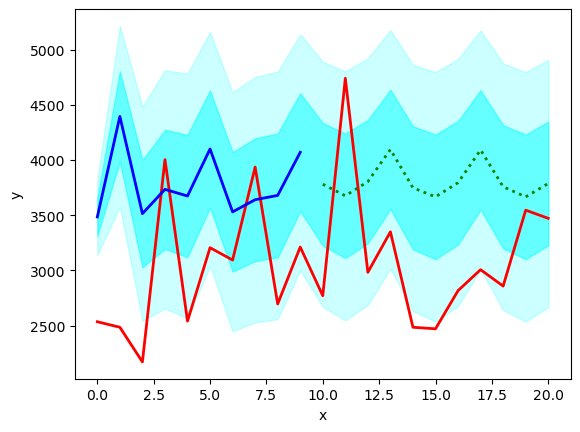

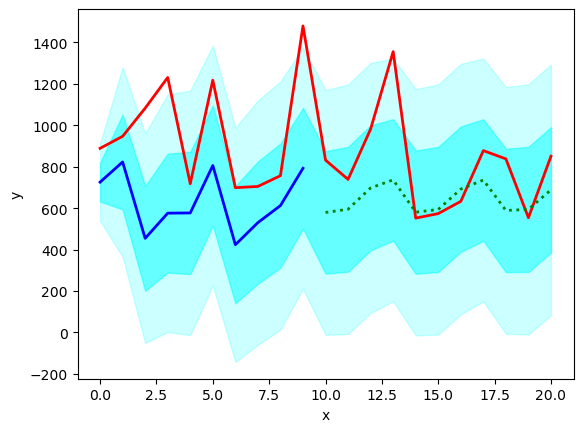

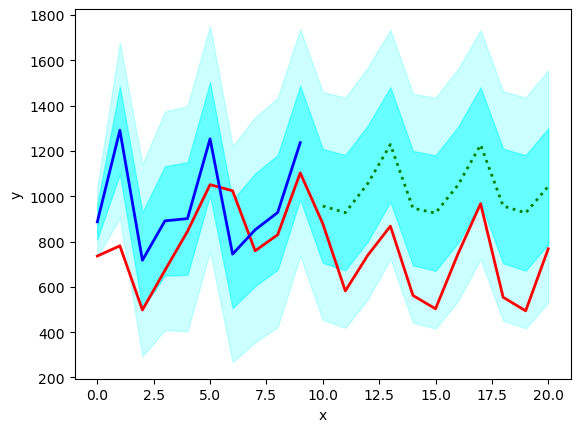

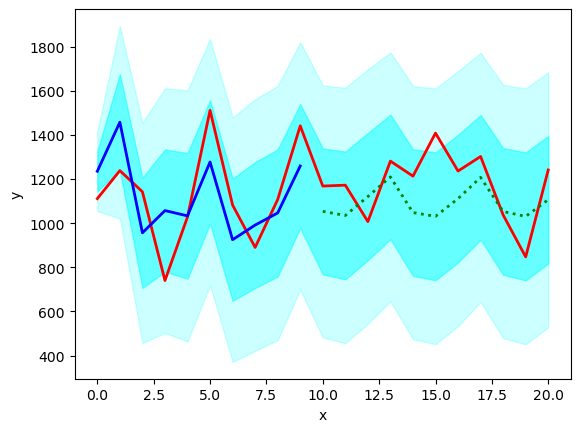

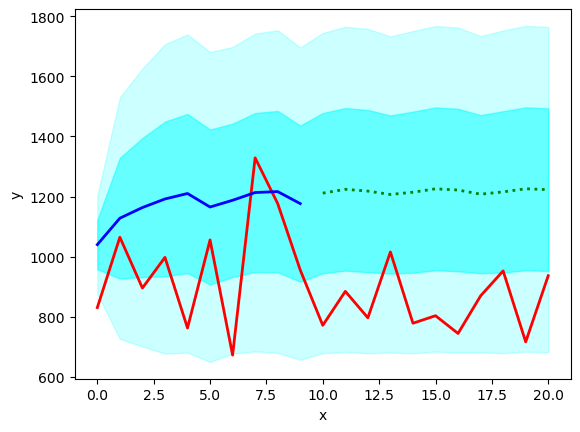

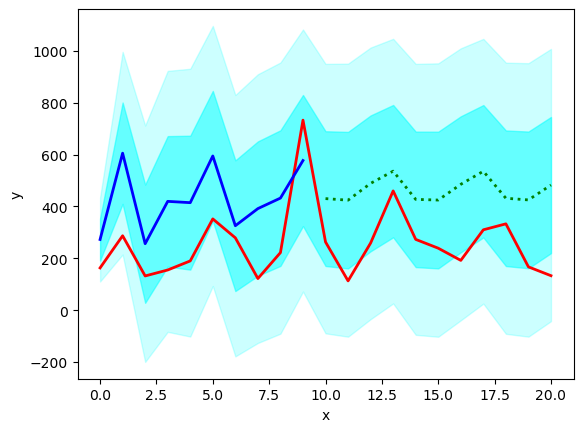

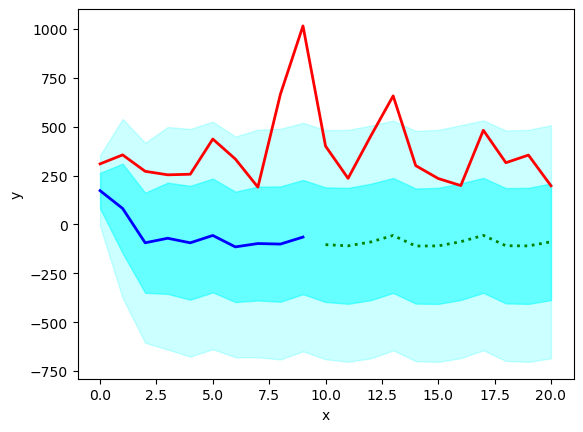

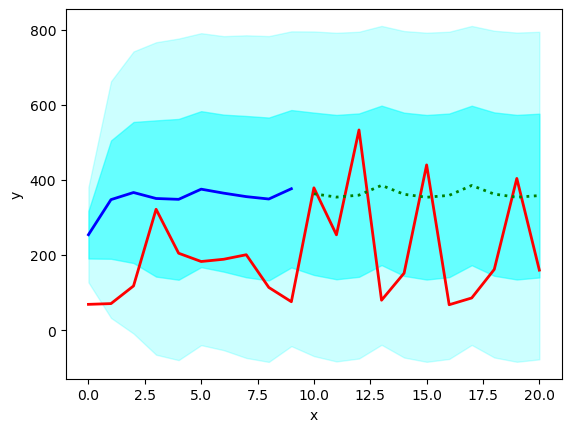

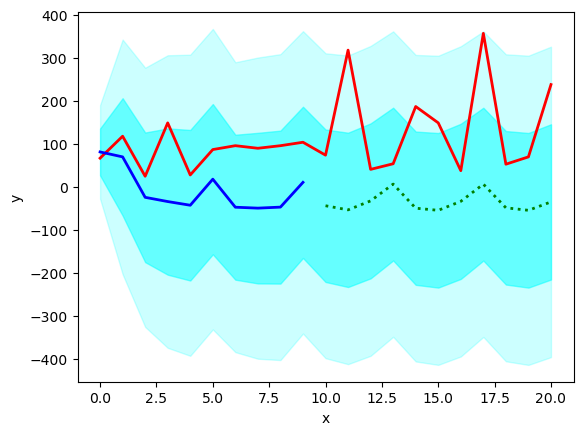

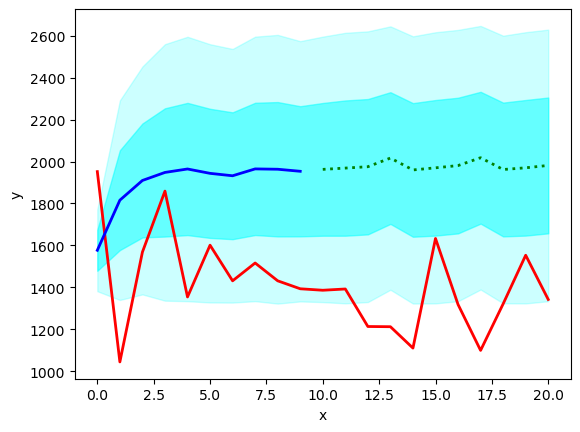

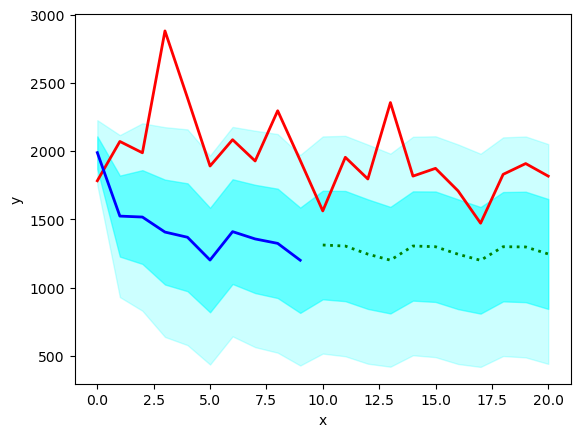

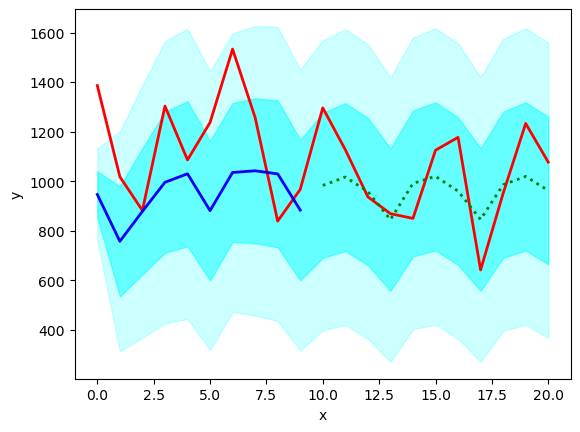

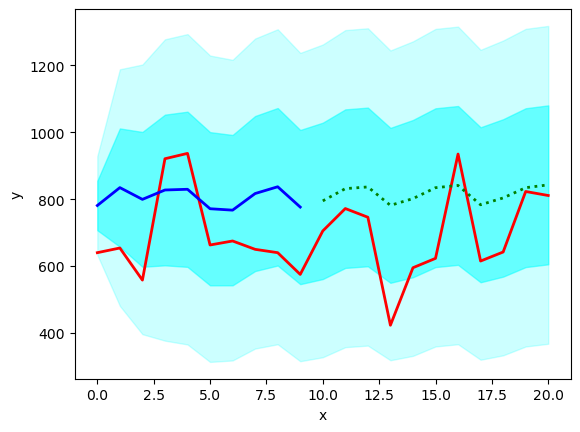

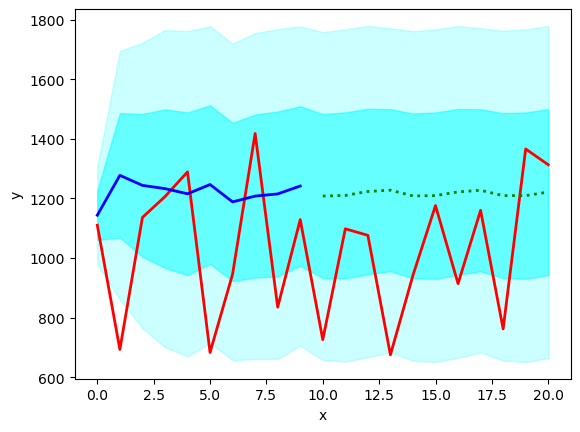

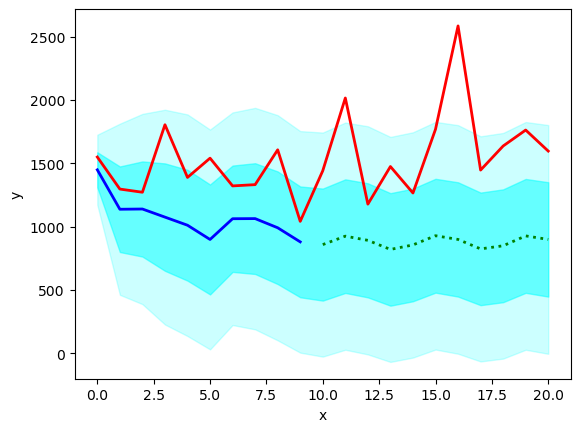

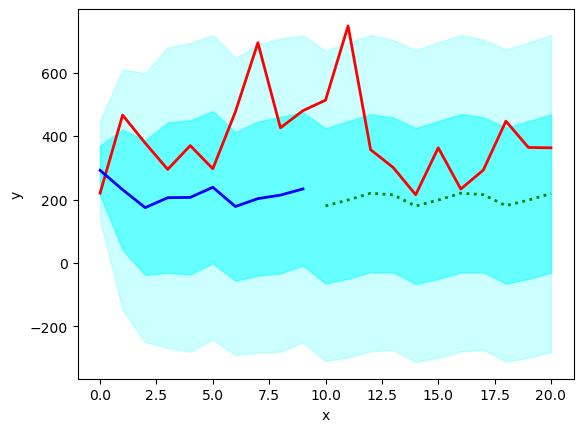

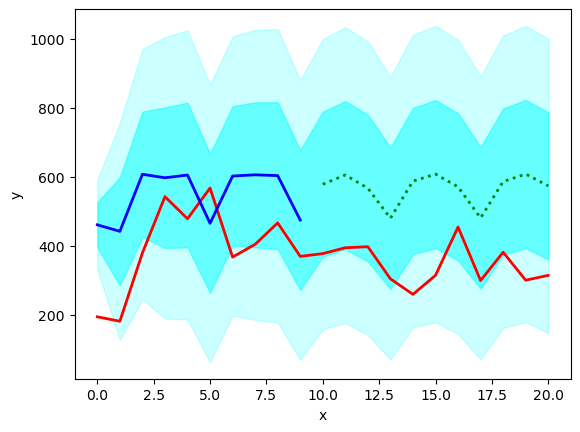

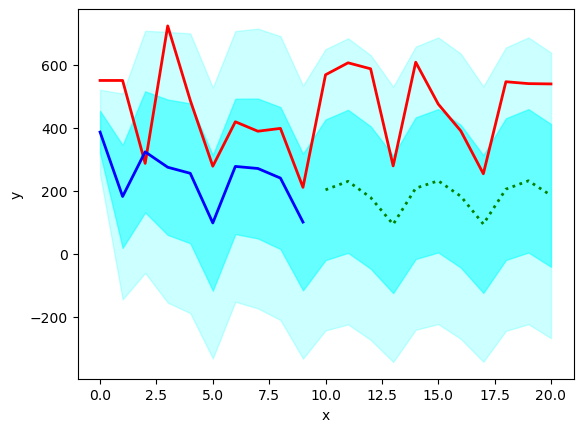

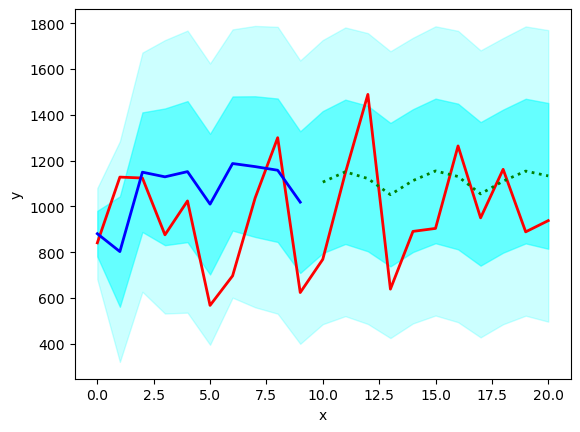

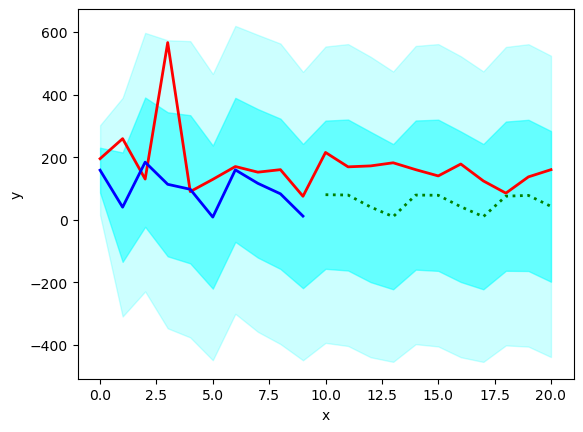

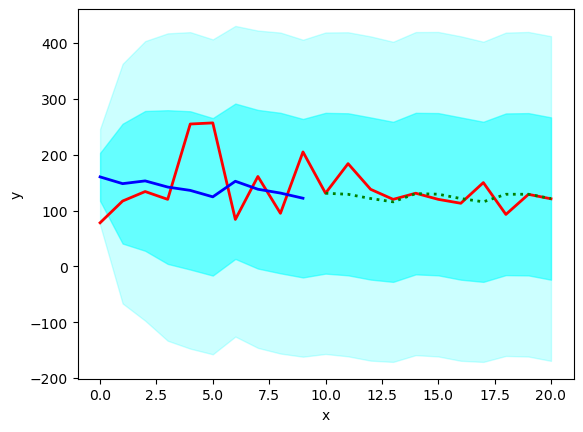

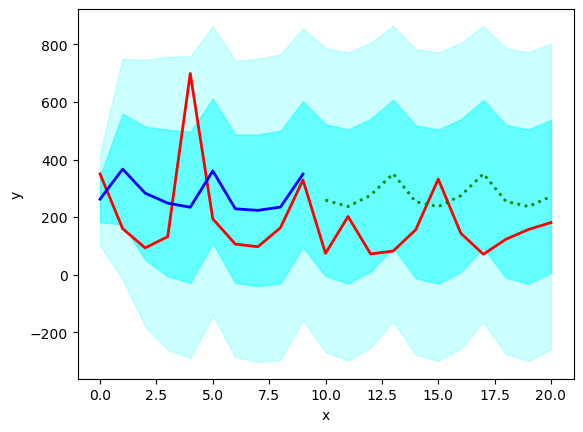

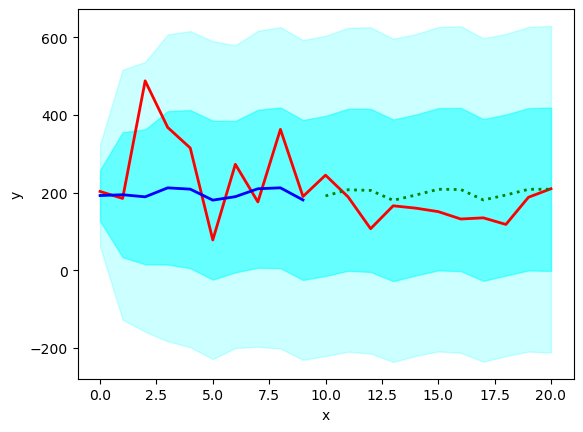

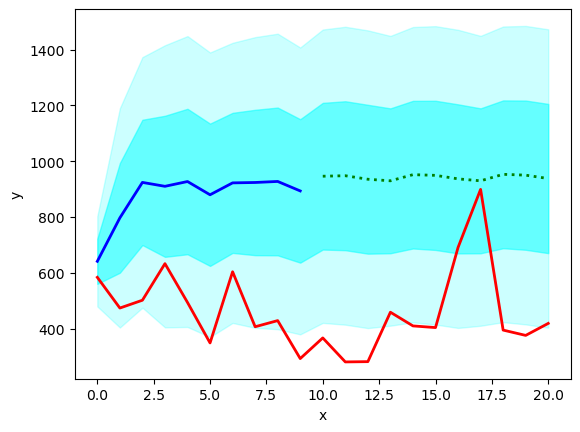

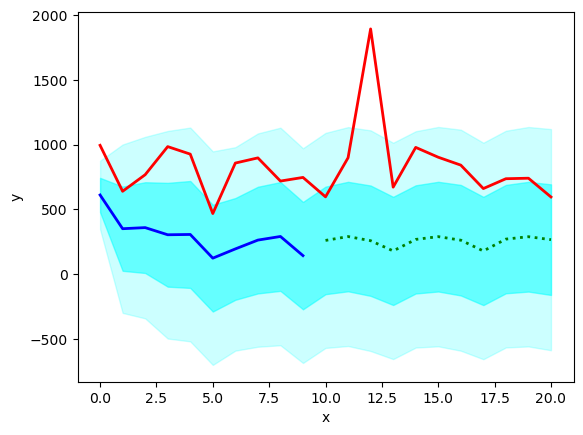

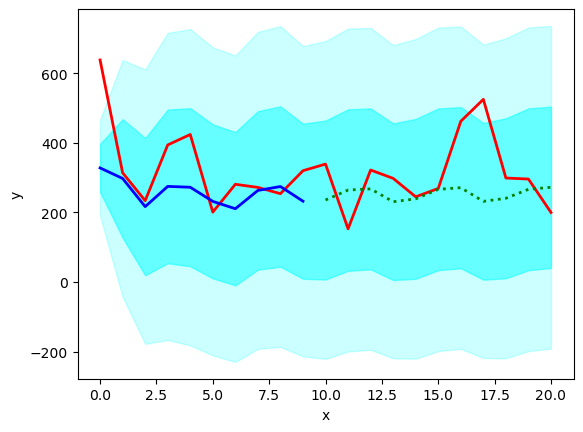

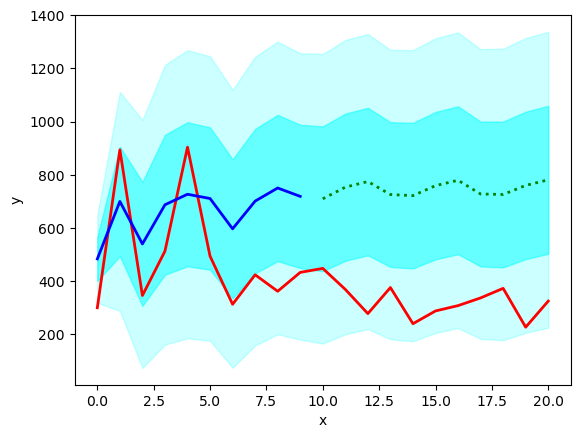

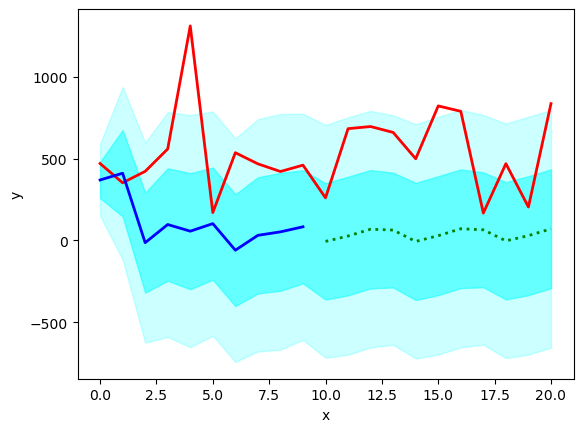

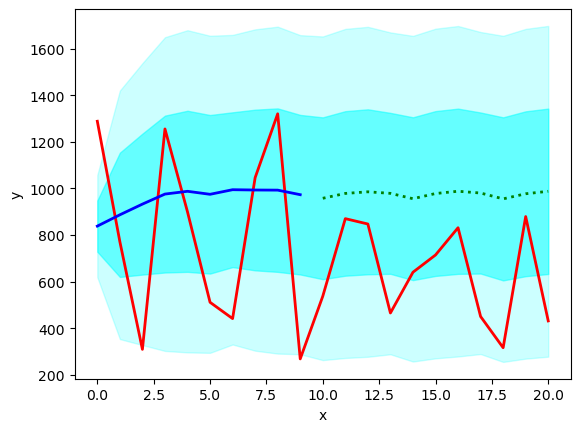

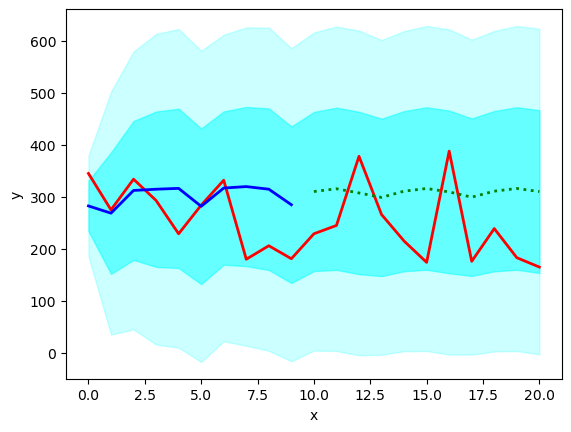

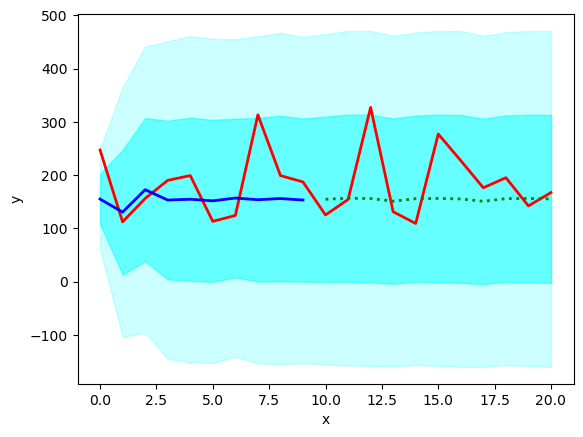

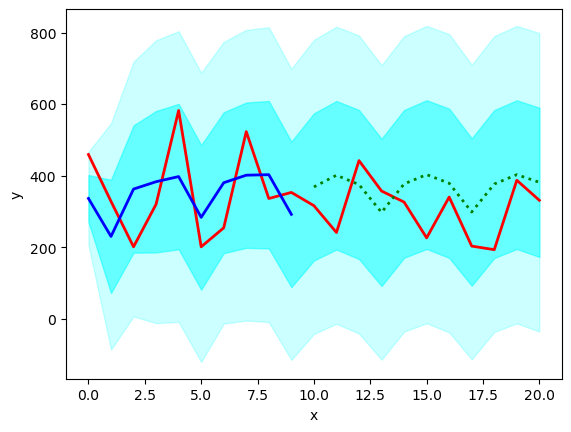

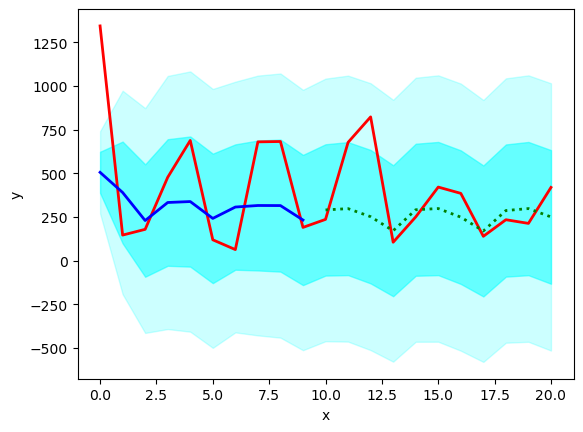

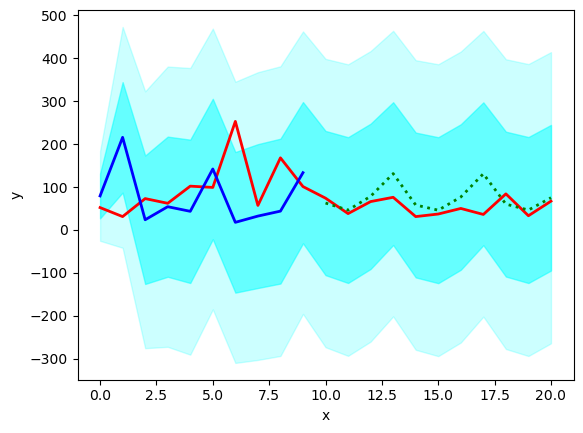

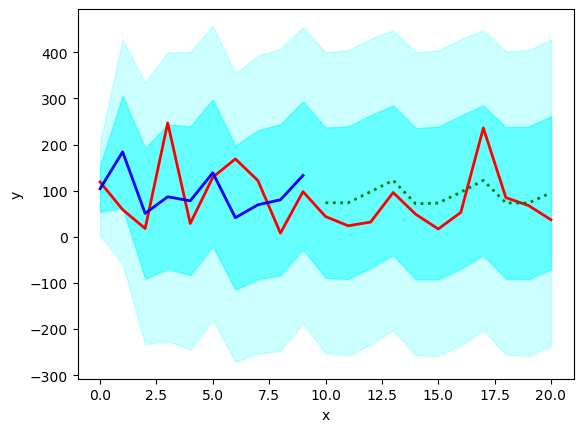

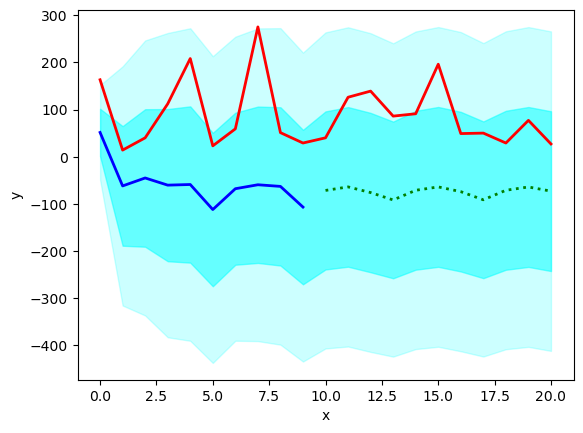

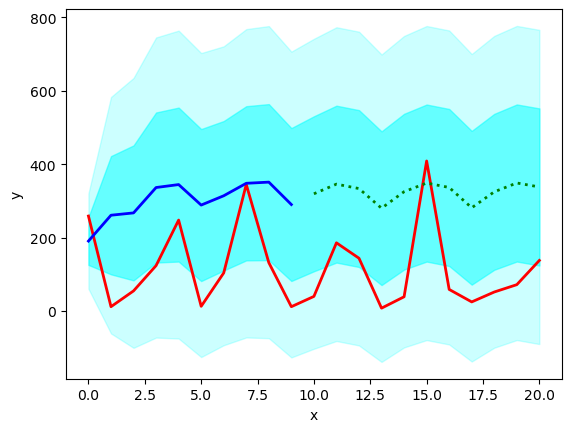

In [40]:
test_dataloader_iter = iter(test_dataloader)
for i in range(0, 1):
    test_batch = next(test_dataloader_iter)
    with torch.no_grad():
        input, target, covariates = utils.split_batch(test_batch)
        input, covariates = utils.scale(input, covariates)
        pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
        pred = utils.invert_scale(pred, True)
        loss = model.NLL(pred, target,ht)
        print("loss (prediction): {0}".format(loss))
        preds = pred[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        for i,j in zip(ht,range(len(ht))):
            preds[:, j:j+1, 0]=np.sum(preds[:, i[0]:i[1], 0:1],axis=1)
            preds[:, j:j+1, 1]=np.sum(preds[:, i[0]:i[1], 1:2]**2,axis=1)**0.5
            
    for j in range(num_targets):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        target = targets[:, j]
        plt.figure()

        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(target)), target, 'r', linewidth=2.0)
        plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
        plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0)
        plt.fill_between(np.arange(len(target)), pred - std, pred + std, color='cyan', alpha=0.5)
        plt.fill_between(np.arange(len(target)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)